In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload

%autoreload 2

In [2]:
tf.executing_eagerly()

True

In [3]:
list_ds = tf.data.experimental.make_csv_dataset(
            os.path.join(os.getcwd(), '..', 'data', 'final_dataset_val_demo.csv'),
            batch_size=1,
            num_epochs=1,
            label_name='has_animal',
            prefetch_buffer_size=None,
            num_rows_for_inference=100,
            compression_type=None,
            ignore_errors=False
            )

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


In [4]:
def show_batch(dataset):
    for batch, label in dataset.take(4):
        for key, value in batch.items():
            print("{:20s}: {}".format(key,value.numpy()))
        print(label.numpy())

In [5]:
show_batch(list_ds)

sequence            : [21]
image1              : [b'120516010928001a1601.jpg']
image2              : [b'120516010928001a1602.jpg']
image3              : [b'120516010928001a1603.jpg']
[1]
sequence            : [24]
image1              : [b'090516043918001a1601.jpg']
image2              : [b'090516043918001a1602.jpg']
image3              : [b'090516043918001a1603.jpg']
[0]


In [45]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    return img

In [24]:
def parse_data(metadata, label):
    data_point = {}
    for img_name in ['image1', 'image2', 'image3']:
        img = tf.io.read_file(tf.strings.join([os.path.join(os.getcwd(), '..', 'data', 'images'), 
                                               os.sep, metadata[img_name]])[0])
        img = decode_img(img)
        data_point[img_name] = img
    return data_point, label

In [25]:
new_ds = list(list_ds.map(parse_data, num_parallel_calls=tf.data.experimental.AUTOTUNE))

In [26]:
new_ds[0]

({'image1': <tf.Tensor: id=377, shape=(2448, 3264, 3), dtype=float32, numpy=
  array([[[0.07058824, 0.07058824, 0.07058824],
          [0.06666667, 0.06666667, 0.06666667],
          [0.09019608, 0.09019608, 0.09019608],
          ...,
          [0.45098042, 0.45098042, 0.45098042],
          [0.40784317, 0.40784317, 0.40784317],
          [0.37254903, 0.37254903, 0.37254903]],
  
         [[0.07450981, 0.07450981, 0.07450981],
          [0.07843138, 0.07843138, 0.07843138],
          [0.10588236, 0.10588236, 0.10588236],
          ...,
          [0.43529415, 0.43529415, 0.43529415],
          [0.40784317, 0.40784317, 0.40784317],
          [0.38823533, 0.38823533, 0.38823533]],
  
         [[0.07058824, 0.07058824, 0.07058824],
          [0.07843138, 0.07843138, 0.07843138],
          [0.10196079, 0.10196079, 0.10196079],
          ...,
          [0.4156863 , 0.4156863 , 0.4156863 ],
          [0.40784317, 0.40784317, 0.40784317],
          [0.40784317, 0.40784317, 0.40784317]],
  
  

In [47]:
def show_batch(image_batch, label_batch, k=2):
    plt.figure(figsize=(10,10))
    for n in range(k):
        ax = plt.subplot(1, k, n + 1)
        plt.imshow(image_batch[n])
        plt.axis('off')
        plt.title(label_batch[n].numpy())

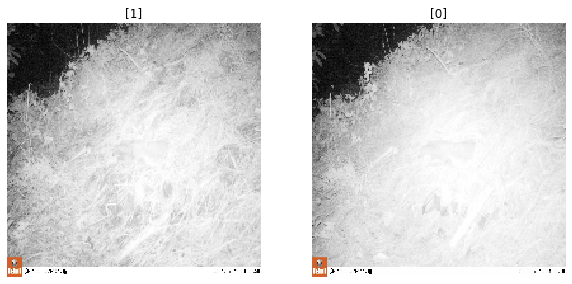

In [13]:
image_batch = [img for img, lab in new_ds]
label_batch = [lab for img, lab in new_ds]
show_batch(image_batch, label_batch)

## Alternative Pipeline Test

In [3]:
data_csv = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'final_dataset_val_demo.csv'))

In [6]:
data_csv.head()

,sequence,image1,image2,image3,has_animal
0,21,120516010928001a1601.JPG,120516010928001a1602.JPG,120516010928001a1603.JPG,1
1,24,090516043918001a1601.JPG,090516043918001a1602.JPG,090516043918001a1603.JPG,0


In [9]:
file_paths = data_csv[['image1', 'image2', 'image3']]
labels = data_csv[['has_animal']]

In [40]:
dataset_files = tf.data.Dataset.from_tensor_slices((file_paths.to_dict('list'), labels.values.reshape(-1, )))

In [43]:
def parse_data(metadata, label):
    data_point = {}
    for img_name in ['image1', 'image2', 'image3']:
        img = tf.io.read_file(tf.strings.join([os.path.join(os.getcwd(), '..', 'data', 'images'), 
                                               os.sep, metadata[img_name]]))
        img = decode_img(img)
        data_point[img_name] = img
    return data_point, label

In [46]:
dataset_images = dataset_files.map(parse_data)

In [6]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(2):
        ax = plt.subplot(1, 2, n + 1)
        plt.imshow(image_batch[n])
        plt.axis('off')
        plt.title(label_batch[n].numpy())

In [ ]:
new_ds = iter(dataset_images)
image_batch = [img['image1'] for img, lab in new_ds]

new_ds = iter(dataset_images)
label_batch = [lab for img, lab in new_ds]
show_batch(image_batch, label_batch)

In [64]:
next(iter(dataset_images.batch(2)))

({'image1': <tf.Tensor: id=325, shape=(2, 2448, 3264, 3), dtype=float32, numpy=
  array([[[[0.15294118, 0.15294118, 0.15294118],
           [0.14117648, 0.14117648, 0.14117648],
           [0.12941177, 0.12941177, 0.12941177],
           ...,
           [0.34901962, 0.34901962, 0.34901962],
           [0.30588236, 0.30588236, 0.30588236],
           [0.27058825, 0.27058825, 0.27058825]],
  
          [[0.12156864, 0.12156864, 0.12156864],
           [0.1137255 , 0.1137255 , 0.1137255 ],
           [0.1137255 , 0.1137255 , 0.1137255 ],
           ...,
           [0.34509805, 0.34509805, 0.34509805],
           [0.3137255 , 0.3137255 , 0.3137255 ],
           [0.28627452, 0.28627452, 0.28627452]],
  
          [[0.09411766, 0.09411766, 0.09411766],
           [0.09411766, 0.09411766, 0.09411766],
           [0.10588236, 0.10588236, 0.10588236],
           ...,
           [0.34117648, 0.34117648, 0.34117648],
           [0.32941177, 0.32941177, 0.32941177],
           [0.31764707, 0.31764

In [122]:
def parse_data_flat(metadata, label):
    images, labels = [], []
    for img_name in ['image1', 'image2', 'image3']:
        img = tf.io.read_file(tf.strings.join([os.path.join(os.getcwd(), '..', 'data', 'images'), 
                                               os.sep, metadata[img_name]]))
        img = decode_img(img)
        images.append(img)
        labels.append(label)
    return tf.data.Dataset.from_tensor_slices((images, labels))

In [123]:
next(iter(dataset_files.flat_map(parse_data_flat, para).shuffle(buffer_size=10000, reshuffle_each_iteration=True).batch(6)))

(<tf.Tensor: id=1254, shape=(6, 2448, 3264, 3), dtype=float32, numpy=
 array([[[[0.05882353, 0.05882353, 0.05882353],
          [0.05882353, 0.05882353, 0.05882353],
          [0.0627451 , 0.0627451 , 0.0627451 ],
          ...,
          [0.45882356, 0.45882356, 0.45882356],
          [0.45098042, 0.45098042, 0.45098042],
          [0.45098042, 0.45098042, 0.45098042]],
 
         [[0.0509804 , 0.0509804 , 0.0509804 ],
          [0.05882353, 0.05882353, 0.05882353],
          [0.07058824, 0.07058824, 0.07058824],
          ...,
          [0.48627454, 0.48627454, 0.48627454],
          [0.47450984, 0.47450984, 0.47450984],
          [0.45882356, 0.45882356, 0.45882356]],
 
         [[0.06666667, 0.06666667, 0.06666667],
          [0.07450981, 0.07450981, 0.07450981],
          [0.09411766, 0.09411766, 0.09411766],
          ...,
          [0.49803925, 0.49803925, 0.49803925],
          [0.47450984, 0.47450984, 0.47450984],
          [0.45098042, 0.45098042, 0.45098042]],
 
         ...

In [ ]:
[[1,2,3],[4,5,6]]

In [104]:
dataset1 = tf.data.Dataset.from_tensor_slices(
    [[[1,2,3],[4,5,6]], [[1,2,3],[4,5,6]], [[1,2,3],[4,5,6]]])

dataset2 = tf.data.Dataset.from_tensors(
    [np.random.uniform(0, 1, (2, 3)), np.random.uniform(0, 1, (2, 3)), np.random.uniform(0, 1, (2, 3))])

print(next(iter(dataset1))) # shapes: (2, 3)
print(next(iter(dataset2))) # shapes: (2, 2, 3)

tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[[0.25052506 0.60764513 0.32726181]
  [0.19410323 0.78243375 0.17319819]]

 [[0.28262833 0.35615074 0.29835668]
  [0.26616135 0.22813303 0.06946989]]

 [[0.00943217 0.80698453 0.3767025 ]
  [0.37348604 0.8115013  0.1645897 ]]], shape=(3, 2, 3), dtype=float64)


In [105]:
for val in dataset1:
    print(val)

tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)


In [117]:
class Abc:
    RANDCONST = "32"
    
    def check(self, val=RANDCONST):
        return val == self.RANDCONST

In [119]:
Abc().check(22)

False

In [3]:
from data_pipeline import PipelineGenerator

In [55]:
demo_pipeline = PipelineGenerator(os.path.join(os.getcwd(), '..', 'data', 'final_dataset_val_demo.csv'),
                                  os.path.join(os.getcwd(), '..', 'data', 'images' + os.sep), 
                                  mode=PipelineGenerator.MODE_ALL)

#### For all mode

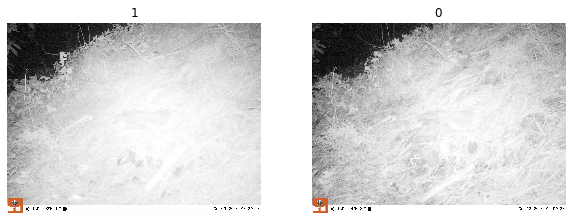

In [56]:
new_ds = iter(demo_pipeline.get_pipeline())
image_batch = [img['image1'] for img, lab in new_ds]

new_ds = iter(demo_pipeline.get_pipeline())
label_batch = [lab for img, lab in new_ds]
show_batch(image_batch, label_batch)

#### For flat mode

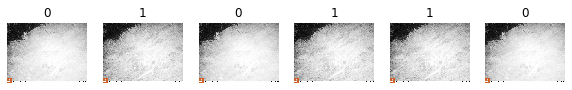

In [49]:
# new_ds = iter(demo_pipeline.get_pipeline())
image_batch, label_batch = zip(*demo_pipeline.get_pipeline().shuffle(buffer_size=1000, reshuffle_each_iteration=True))
show_batch(image_batch, label_batch, k=6)

#### For Single mode

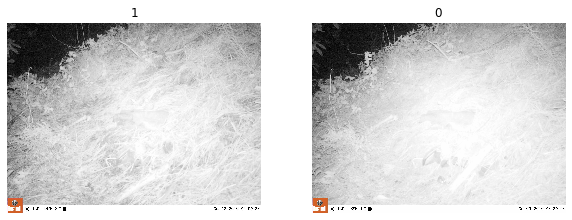

In [54]:
image_batch, label_batch = zip(*demo_pipeline.get_pipeline())
show_batch(image_batch, label_batch)